In [11]:
import torch
from pytorch_grad_cam import GradCAM
import sys
import os
import cv2
import albumentations as A
import torch.nn.functional as F
import numpy as np 
from PIL import Image
from pytorch_grad_cam.utils.image import show_cam_on_image
if "/opt/ml/level2_cv_semanticsegmentation-cv-09" not in sys.path:
    sys.path.append(os.path.join("/opt/ml/level2_cv_semanticsegmentation-cv-09"))

In [12]:
model_path = "/opt/ml/level2_cv_semanticsegmentation-cv-09/checkpoint/hrnet48_ocr_1024_combine_mixup_best.pt"
image_path = "/opt/ml/train/DCM/ID001/image1661130828152_R.png"


In [13]:
model = torch.load(model_path,map_location='cpu')
model.eval()

img = cv2.imread(image_path)
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)



### Make Hook

In [14]:

last_layer = {}
last_grad = 0
handles = []
def hook(name):
    def hook_fn(module,input,output):
        global last_layer
        # last_layer['module'] = module
        last_layer['name'] = name
        last_layer['output'] = output.detach()
    
    return hook_fn

def grad_hook(module, grad_input, grad_output):
    global last_grad
    last_grad = grad_output[0].detach()
    
for name, module in model.named_modules():
    
    if isinstance(module, torch.nn.Conv2d):
        forward_hook = module.register_forward_hook(hook(name))
        backward_hook = module.register_full_backward_hook(grad_hook)
        handles.extend([forward_hook, backward_hook])

## Model Forward

In [15]:
slect_id = 26


class SemanticSegmentationTarget:
    def __init__(self, category, mask):
        self.category = category
        self.mask = torch.from_numpy(mask)
        
    def __call__(self, model_output):
        return (model_output[self.category, :, : ] * self.mask).sum()

In [16]:
print(img.shape)
img = img/255.
img = A.Resize(1024,1024)(image=img)['image']
rgb_img = np.float32(img)
img = img.transpose(2,0,1)
img = torch.from_numpy(img).float().unsqueeze(0)

with torch.autograd.set_grad_enabled(True):
    loss = 0
    output = model(img)
    model.zero_grad()
    normalized_masks = torch.nn.functional.sigmoid(output).cpu()
    for index in range(29):
        masks = normalized_masks[0][index]>0.5
        mask = np.float32(masks==True)
        target = SemanticSegmentationTarget(index,mask)
        loss += target(output[0])
    loss.backward(retain_graph=True)
    # out_mask = torch.zeros((1,output.shape[-1]))
    # out_mask[0][slect_id] = 1
    # score = sum([output[0][class_index].mean() for class_index in range(29)])
    # score.backward(retain_graph=True)

print(f"last layer = {last_layer['name']}")
for handle in handles:
    handle.remove()

(2048, 2048, 3)
last layer = model.cls_head


## Calculate Grad-CAM

In [17]:
# target = last_layer['output'].data.numpy()
# gradient = last_grad.data.numpy()

# weights = np.mean(gradient,axis=(1,2))
# print(weights.shape)


# cam = np.maximum(cam,0)
# cam = (cam - np.min(cam)) / (np.max(cam)- np.min(cam))
# cam = np.uint8(cam*255)

# Image.fromarray(cam)

weights (1, 64) 0.6944132447242737
activation shape (256, 256) 28.79348373413086
weighted_activations (1, 256, 256) 424.81463623046875
grad_cam (1, 256, 256) 0.0 424.81463623046875
result_cam (1024, 1024)
max = 0.911497950553894


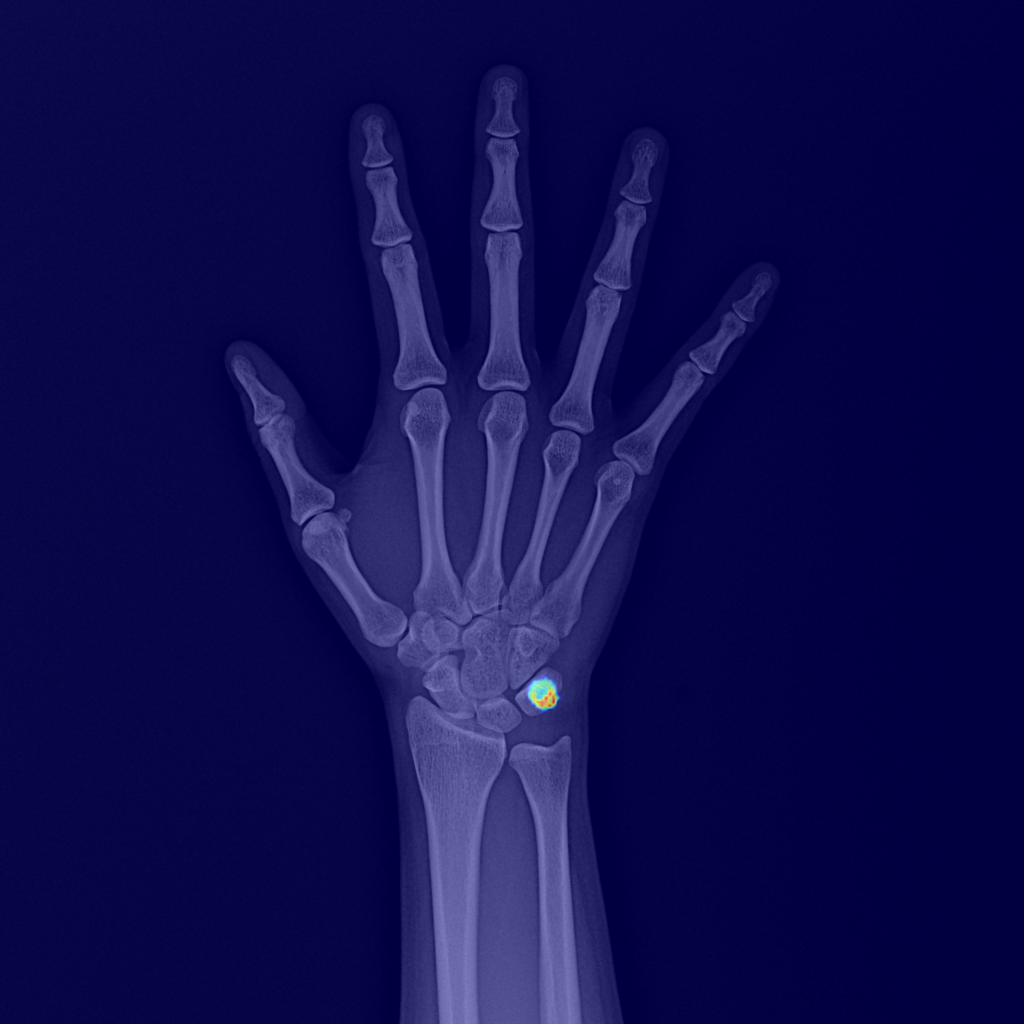

In [18]:
weights = np.mean(last_grad.cpu().data.numpy(), axis=(2,3))
print(f"weights {weights.shape} {weights.max()}")


activation = last_layer['output'][0][slect_id].cpu().data.numpy()
print(f"activation shape {activation.shape} {activation.max()}")
weighted_activations = (weights[:,:,None,None] *activation).sum(axis=1)
print(f"weighted_activations {weighted_activations.shape} {weighted_activations.max()}")
grad_cam = np.maximum((weighted_activations),0)
print(f"grad_cam {grad_cam.shape} {grad_cam.min()} {grad_cam.max()}")
normal_cam = (grad_cam - grad_cam.min())/(1e-7 +grad_cam.max())
result_cam = cv2.resize(normal_cam[0], (img.size(-2),img.size(-1)))
print(f"result_cam {result_cam.shape}")
# m_cam = result_cam - np.min(result_cam)
# normal_cam = m_cam / np.max(m_cam)
# m_cam = np.maximum(result_cam, 0)
print(f"max = {np.max(result_cam)}")
# grad_cam = F.interpolate(grad_cam, size=(img.size(-2),img.size(-1)),)
c_image = show_cam_on_image(rgb_img, result_cam, use_rgb=True)


Image.fromarray(c_image)


In [19]:
normalized_masks = torch.nn.functional.sigmoid(output).cpu()

mask = normalized_masks[0,slect_id]>0.5
print(mask.shape)
# class_mask_uint8 = 255*np.uint8(mask==True)
class_mask_float = np.float32(mask==True)

torch.Size([256, 256])


(1024, 1024)


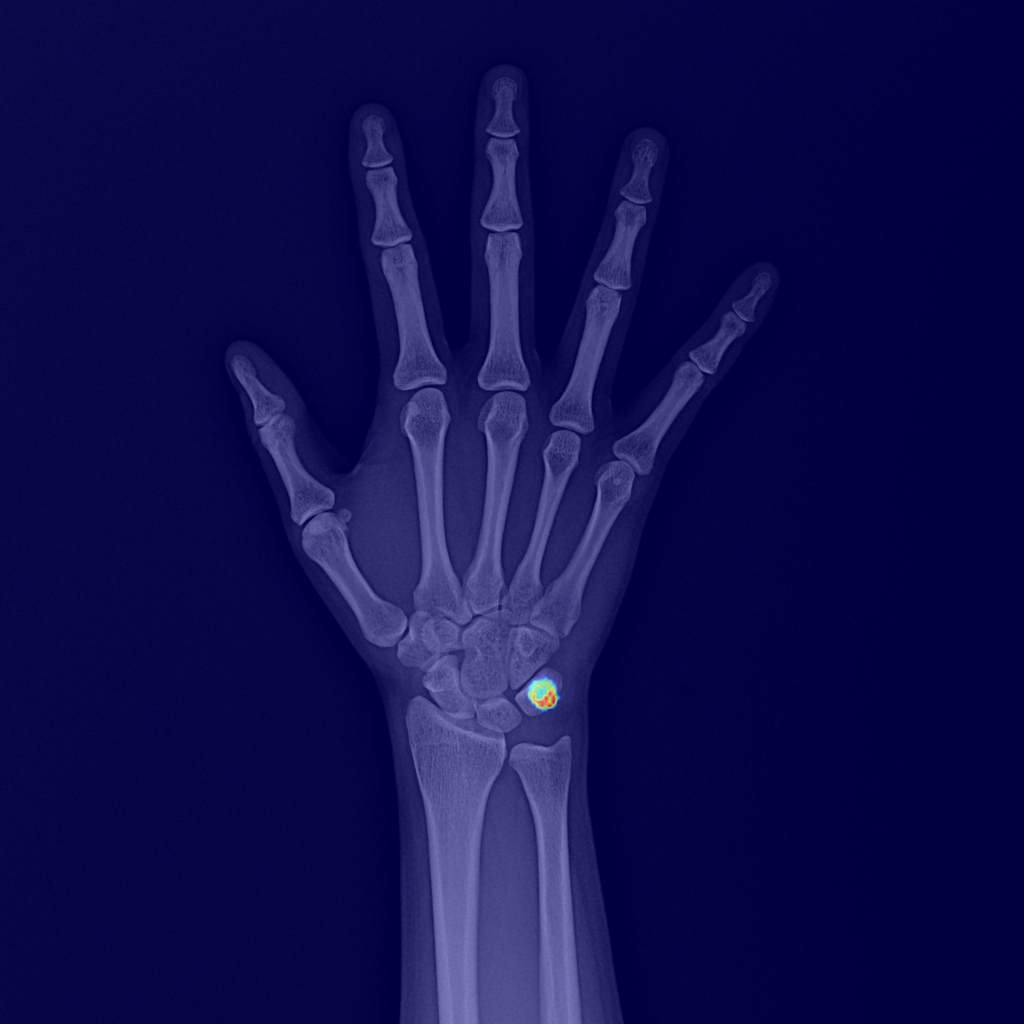

In [20]:
   
target_layers = [model.model.cls_head]
targets = [SemanticSegmentationTarget(slect_id, class_mask_float)]
with GradCAM(model=model,
             target_layers=target_layers,
             use_cuda=False) as cam:
    grayscale_cam = cam(input_tensor=img,
                        targets=targets)[0, :]
    print(grayscale_cam.shape)
    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

Image.fromarray(cam_image)